# TextGrad Tutorials: MultiModal Optimization

![TextGrad](https://github.com/vinid/data/blob/master/logo_full.png?raw=true)

An autograd engine -- for textual gradients!

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/zou-group/TextGrad/blob/main/examples/notebooks/Prompt-Optimization.ipynb)
[![GitHub license](https://img.shields.io/badge/License-MIT-blue.svg)](https://lbesson.mit-license.org/)
[![Arxiv](https://img.shields.io/badge/arXiv-2406.07496-B31B1B.svg)](https://arxiv.org/abs/2406.07496)
[![Documentation Status](https://readthedocs.org/projects/textgrad/badge/?version=latest)](https://textgrad.readthedocs.io/en/latest/?badge=latest)
[![PyPI - Python Version](https://img.shields.io/pypi/pyversions/textgrad)](https://pypi.org/project/textgrad/)
[![PyPI](https://img.shields.io/pypi/v/textgrad)](https://pypi.org/project/textgrad/)

**Objectives for this tutorial:**

* Introduce you to multimodal optimization with TextGrad

**Requirements:**

* You need to have an OpenAI API key to run this tutorial. This should be set as an environment variable as OPENAI_API_KEY.


In [50]:
# Some utils to read images

import io
from PIL import Image

In [51]:
import textgrad as tg

# differently from the past tutorials, we now need a multimodal LLM call instead of a standard one!
from textgrad.autograd import MultimodalLLMCall
from textgrad.loss import ImageQALoss

In [55]:
from anthropic import Anthropic
tg.set_backward_engine("claude-3-opus-20240229", override=True)

# Simply answering questions about images

We now downlaod an image from the web.

In [89]:
import httpx

image_url = "https://raw.githubusercontent.com/pytorch/serve/master/docs/images/kitten_small.jpg"
image_data = httpx.get(image_url).content

In [90]:
import io
import requests
from PIL import Image
import textgrad as tg

def load_image_from_url_as_jpeg_bytes(url):

    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36"
    }

    print(f"正在下载图片: {url} ...")

    response = requests.get(url, headers=headers)
    response.raise_for_status()

    with Image.open(io.BytesIO(response.content)) as img:
        if img.mode == 'RGBA':
            img = img.convert('RGB')

        byte_arr = io.BytesIO()
        img.save(byte_arr, format='JPEG')
        return byte_arr.getvalue()

url = "https://raw.githubusercontent.com/pytorch/serve/master/docs/images/kitten_small.jpg"


image_bytes = load_image_from_url_as_jpeg_bytes(url)
print("图片下载并处理成功！")

正在下载图片: https://raw.githubusercontent.com/pytorch/serve/master/docs/images/kitten_small.jpg ...
图片下载并处理成功！


As usual, in TextGrad we now have to transform our object of interest into a Variable object. In the previous tutorials, we were doing this with text data, now we are going to do this with Images.

In [91]:
image_variable = tg.Variable(image_bytes, role_description="image to answer a question about", requires_grad=False)

Let's now ask as question!

In [92]:
question_variable = tg.Variable("What do you see in this image?", role_description="question", requires_grad=False)
response = MultimodalLLMCall("claude-3-opus-20240229")([image_variable, question_variable])
response

INFO:textgrad:MultimodalLLMCall function forward


Variable(value=This image shows a close-up portrait of an adorable tabby kitten. The kitten has a fluffy, striped coat with shades of brown, black and white fur. Its eyes are wide open, revealing a bright, alert expression. The kitten's small pink nose and mouth are visible, giving it an incredibly cute appearance.

The image captures the kitten's face in great detail, highlighting its soft, downy fur and whiskers. The kitten seems to be looking directly at the camera with an engaging and playful gaze that is typical of young, curious felines. Overall, it's a charming, heartwarming photo showcasing the irresistible cuteness of a baby cat., role=response from the language model, grads=set())

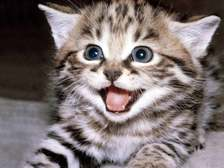

In [93]:
Image.open(io.BytesIO(image_data))

In [95]:
loss_fn = ImageQALoss(
    evaluation_instruction="Does this seem like a complete and good answer for the image? Criticize. Do not provide a new answer.",
    engine="claude-3-opus-20240229"
)
loss = loss_fn(question=question_variable, image=image_variable, response=response)
loss

INFO:textgrad:MultimodalLLMCall function forward


Variable(value=The provided answer is quite comprehensive and does a good job describing the key elements and overall impression of the kitten portrait. It covers the kitten's physical appearance, including its fur colors and patterns, facial features, and expression. The answer also touches on the emotional appeal and cuteness captured in the photo.

However, there are a few areas where the answer could be slightly improved or expanded:

1. The answer could provide more specific details about the kitten's fur, such as mentioning that the stripes appear primarily on its forehead, cheeks, and potentially its body (though not fully visible in this close-up shot).

2. It might be worth noting the kitten's ears and their position, as they are a prominent feature in the image and contribute to its alert, attentive expression.

3. The description of the kitten's gaze as "playful" could be debated, as the wide-eyed look might be more indicative of curiosity, alertness, or even a slight sense 

In [96]:
optimizer = tg.TGD(parameters=[response])
loss.backward()
optimizer.step()
print(response.value)

INFO:textgrad:_backward_through_llm prompt
INFO:textgrad:_backward_through_llm gradient
INFO:textgrad:TextualGradientDescent prompt for update
INFO:textgrad:TextualGradientDescent optimizer response
INFO:textgrad:TextualGradientDescent updated text


This image showcases a charming close-up portrait of an adorable tabby kitten. The kitten's fluffy coat features a striking pattern of brown, black, and white stripes, with the markings being most prominent on its forehead and cheeks. Its ears are small and pointed, standing alert and contributing to the kitten's attentive, curious expression.

The kitten's bright, wide eyes are a focal point, conveying a sense of alertness and engagement as it seems to gaze directly at the camera. The details of its small pink nose and mouth add to its undeniable cuteness. 

The portrait is skillfully captured with a shallow depth of field, blurring the background and emphasizing the kitten's face as the central subject. This photographic technique enhances the image's impact and draws the viewer's attention to the kitten's endearing features and soft, downy fur.

Overall, this heartwarming photo showcases the irresistible charm and beauty of a young kitten, with its captivating eyes, striking coat, a